In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import string
import re
import spacy
import gensim
import warnings
warnings.filterwarnings("ignore")

### **Plan of Action**

1. Load data
2. EDA
3. Feature engineering
4. Topic modelling
    - BerTopic
5. Repeat step 4

### **Load data**

In [2]:
df = pd.read_csv("../topic_data.csv")

### **Feature engineering**

In [3]:
df_copy = df.copy()
df_copy.describe()

raw_text_length    year        month  cleaned_text_length
count      4568.000000  4568.0  4568.000000          4568.000000
mean         27.330560  2023.0     3.703590            24.769483
std          11.840659     0.0     0.456724            11.581002
min           1.000000  2023.0     3.000000             1.000000
25%          17.000000  2023.0     3.000000            15.000000
50%          27.000000  2023.0     4.000000            24.000000
75%          37.000000  2023.0     4.000000            34.000000
max          61.000000  2023.0     4.000000            57.000000

In [4]:
df_copy.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4568 entries, 0 to 4567
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   text                 4568 non-null   object
 1   date                 4568 non-null   object
 2   raw_text_length      4568 non-null   int64 
 3   year                 4568 non-null   int64 
 4   month                4568 non-null   int64 
 5   cleaned_text         4568 non-null   object
 6   cleaned_text_length  4568 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 3.2 MB


**Memory management**

In [5]:
# Memory management
def memory_magment(df):
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != np.object:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8) # int 8
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16) # int 16
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)  # in 32
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64) # int 64 
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else: 
                    df[col] = df[col].astype(np.float64)
    return df
df_memory = df_copy.copy()
df_memory = memory_magment(df_memory)    

In [6]:
df_memory.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4568 entries, 0 to 4567
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   text                 4568 non-null   object
 1   date                 4568 non-null   object
 2   raw_text_length      4568 non-null   int8  
 3   year                 4568 non-null   int16 
 4   month                4568 non-null   int8  
 5   cleaned_text         4568 non-null   object
 6   cleaned_text_length  4568 non-null   int8  
dtypes: int16(1), int8(3), object(3)
memory usage: 3.1 MB


In [7]:
featured_data = df_memory[['text']]

In [8]:
featured_data

text
0     "Ah, yes. I just love waking up to the sweet a...
1     When @ViolavonCramon\nflies to Georgia 🇬🇪 to t...
2     Exclusive — Rep. Jeff Van Drew: Democrats Afra...
3     It’s April 03, 2023 at 12:29PM\nStop Your Peri...
4     #PMAtCBIDiamondJubilee\nCorruption and dynasti...
...                                                 ...
4563  If the Word cannot provoke you to preach the g...
4564  cept\nmy own and that of the manager.\n\n"'My ...
4565  Graham Potter's Chelsea exit set for huge impa...
4566  How to watch Manchester United vs Brentford - ...
4567  Erik ten Hag has contradicted himself over Wou...

[4568 rows x 1 columns]

In [9]:
docs = featured_data['text'].tolist()

In [10]:
docs[0]

'"Ah, yes. I just love waking up to the sweet aroma of political chaos and corruption in the morning. It\'s like a breath of fresh air...if that air was filled with hot garbage." #politics #sarcasm'

### **BerTopic**

In [2]:
# Source code: https://github.com/MaartenGr/BERTopic/blob/master/bertopic/_bertopic.py
# Sentence transformers: https://www.sbert.net/docs/pretrained_models.html
# all-MiniLM-L6-v2 - default sentence transformer 80MB
from bertopic import BERTopic

In [3]:
from sentence_transformers import SentenceTransformer
import pickle
# sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
# # Saving transformer to disk
# pickle.dump(sentence_model, open('sentence_transformer/sentence_model.pkl', 'wb'))

In [4]:
# loading transformer
sentence_model = pickle.load(open('../sentence_transformer/sentence_model.pkl','rb'))

In [14]:
# https://github.com/MaartenGr/BERTopic/issues/911
# https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html#gensim
# For reproducibility use this approach
model = BERTopic(verbose=True,
                min_topic_size=50, # minimum documents in a topic
                n_gram_range=(1,2),
                calculate_probabilities=True,embedding_model=sentence_model)
topics, probs = model.fit_transform(docs)

Batches:   0%|          | 0/143 [00:00<?, ?it/s]

2023-05-01 16:11:14,694 - BERTopic - Transformed documents to Embeddings
2023-05-01 16:12:10,799 - BERTopic - Reduced dimensionality
2023-05-01 16:12:11,587 - BERTopic - Clustered reduced embeddings


**Topic Information**

In [17]:
model.get_topic_info()
# model.get_topic_info().to_csv("model_list_versions/topics_7/topics_7.csv")
# Topic -- > Topic number, -1 are the outliers
# Count --> number of documents in the topic; 369
# Name --> Topic_number_collection of the words represent, that document

Topic  Count                                   Name
0     -1    156            -1_https_https co_co_judges
1      0   1723                0_the_co_https_https co
2      1    958               1_ai_healthcare_co_https
3      2    957            2_co_https_https co_manager
4      3    420                3_virus_the_co_https co
5      4    229    4_nigeriadecides2023_the_of_nigeria
6      5     64  5_jdc_boycott_way eligible_cell which
7      6     61          6_gt_your period_period_gt gt

**Selecting the a topic**

In [18]:
model.get_topic(-1) # the  outliers topic

[('https', 0.0787477765918329),
 ('https co', 0.0787477765918329),
 ('co', 0.0786541995470042),
 ('judges', 0.03372004580241427),
 ('by', 0.031690220940829315),
 ('gt', 0.02834216326263076),
 ('was', 0.025070800817566324),
 ('them', 0.025046827402722804),
 ('truth', 0.024899738580714304),
 ('afnn', 0.02404943386356628)]

In [19]:
model.get_topic(0) # Topic 0

[('the', 0.04331113894209089),
 ('co', 0.030021847123864957),
 ('https', 0.030017192113002484),
 ('https co', 0.030017192113002484),
 ('of', 0.027974098558949657),
 ('and', 0.025945119265520778),
 ('in', 0.025396942816890505),
 ('to', 0.02512923563461644),
 ('corruption', 0.023838814579338046),
 ('usa', 0.022100636507997568)]

**Getting documents that represent the topic cluster**

In [20]:
# representative_docs = model.get_representative_docs() # all topics
representative_docs = model.get_representative_docs(3) # single topic
# print(f"Documents:\n{representative_docs}\n")
for document in representative_docs:
    print(f"Documents:\n{document}\n")

Documents:
Since December 2019, SARS-CoV-2 has been circulating in northern Italy. The virus is being detected through environmental monitoring and there have been no reported cases of the virus so far.
https://t.co/BvaBRm4ZIM

Documents:
The SARS-CoV-2 virus is already spreading in France, officials have warned.The warning comes after two cases of the virus were confirmed in the country in December
https://t.co/bGJr2J2BHG

Documents:
The recent COVID-19 pandemic has caused concern on a global scale. There is a need to find ways to address airborne transmission of the virus.We need to find a way to prevent the spread of this virus through the air
https://t.co/kfcu3SUfA5



**Converting the model found topic into dataframe**

In [21]:
data = {"topic":topics, 'document':docs}
df = pd.DataFrame(data)
df.to_csv("model_list_versions/topics_7/topic_7_documents.csv")

**Visualisation**

In [23]:
model.visualize_topics()

# Saving the visuals
# fig = model.visualize_topics()
# fig.write_html("visuals/topics_7/topics_7_visualize_topics.html")

In [24]:
model.visualize_documents(docs=docs,hide_annotations=True)

In [25]:
# Saving the visuals
fig = model.visualize_documents(docs=docs,hide_annotations=True)
fig.write_html("visuals/topics_7/topics_7_visualize_documents.html")

**Observations**

The following can be observed from the plot above;
- Topic 2 is related to sports.
- Topics 4 and 6 are somewhat related to Nigeria and politics.
- Topic 1 is related to AI and healthcare.
- Topics 5 and 3 are related to disaster
- Topic 0 is related to USA and politics

In [26]:
# representative_docs = model.get_representative_docs() # all topics
representative_docs = model.get_representative_docs(4) # single topic
# print(f"Documents:\n{representative_docs}\n")
for document in representative_docs:
    print(f"Documents:\n{document}\n")

Documents:
Daddy of Modern Politics.
Daddy of Politics without bitterness.
Daddy of Issue Based Politics.
Daddy of Politics of Competence.
Daddy of Politics without corruption.
We Love you Daddy, Yes Daddy! 

Give Daddy of OBIdients a Big ❤️ https://t.co/H9Lta7eaeg

Documents:
Daddy of Modern Politics.
Daddy of Politics without bitterness.
Daddy of Issue Based Politics.
Daddy of Politics of Competence.
Daddy of Politics without corruption.
We Love you Daddy, Yes Daddy! 

Give Daddy of OBIdients a Big ❤️ https://t.co/Qr4HKRNJxk

Documents:
Daddy of Modern Politics.
Daddy of Politics without bitterness.
Daddy of Issue Based Politics.
Daddy of Politics of Competence.
Daddy of Politics without corruption.
We Love you Daddy, Yes Daddy! 

Give Daddy of OBIdients a Big ❤️ https://t.co/Wn0MhcEQaE



In [27]:
# representative_docs = model.get_representative_docs() # all topics
representative_docs = model.get_representative_docs(6) # single topic
# print(f"Documents:\n{representative_docs}\n")
for document in representative_docs:
    print(f"Documents:\n{document}\n")

Documents:
It’s April 02, 2023 at 10:29AM
Stop Your Period Pain Instantly and Naturally with Nuvapad, No Drugs.

😍 Experience Your Period Better!
Click &gt;&gt;&gt; https://t.co/TXx3nTRHa6

#AtikuGate #ObiDatti2023 #NigeriaDecides2023 #ThePeoplesTownHall https://t.co/iZz2Nn2EDa

Documents:
It’s April 01, 2023 at 10:29AM
Stop Your Period Pain Instantly and Naturally with Nuvapad, No Drugs.

😍 Experience Your Period Better!
Click &gt;&gt;&gt; https://t.co/TXx3nTRHa6

#AtikuGate #ObiDatti2023 #NigeriaDecides2023 #ThePeoplesTownHall https://t.co/IfMWWAkg0n

Documents:
It’s April 02, 2023 at 01:29AM
Stop Your Period Pain Instantly and Naturally with Nuvapad, No Drugs.

😍 Experience Your Period Better!
Click &gt;&gt;&gt; https://t.co/TXx3nTRHa6

#AtikuGate #ObiDatti2023 #NigeriaDecides2023 #ThePeoplesTownHall https://t.co/umxoVmroXk



In [28]:
# representative_docs = model.get_representative_docs() # all topics
representative_docs = model.get_representative_docs(5) # single topic
# print(f"Documents:\n{representative_docs}\n")
for document in representative_docs:
    print(f"Documents:\n{document}\n")

Documents:
JDC stands for Jafria Disaster Cell which is in no way eligible for zakat and sadqa of Muslims.

Boycott JDC
Boycott Daraz
JDC Exposed
#JDC_EnemiesofIslam 
3

Documents:
3) JDC stands for Jafria Disaster Cell which is in no way eligible for zakat and sadqa of Muslims.

Boycott JDC
Boycott Daraz
JDC Exposed ......
#JDC_EnemiesofIslam

Documents:
JDC stands for Jafria Disaster Cell which is in no way eligible for zakat and sadqa of Muslims.

Boycott JDC
Boycott Daraz
JDC Exposed
#JDC_EnemiesofIslam
ک ک ش ک



In [29]:
# representative_docs = model.get_representative_docs() # all topics
representative_docs = model.get_representative_docs(3) # single topic
# print(f"Documents:\n{representative_docs}\n")
for document in representative_docs:
    print(f"Documents:\n{document}\n")

Documents:
Since December 2019, SARS-CoV-2 has been circulating in northern Italy. The virus is being detected through environmental monitoring and there have been no reported cases of the virus so far.
https://t.co/BvaBRm4ZIM

Documents:
The SARS-CoV-2 virus is already spreading in France, officials have warned.The warning comes after two cases of the virus were confirmed in the country in December
https://t.co/bGJr2J2BHG

Documents:
The recent COVID-19 pandemic has caused concern on a global scale. There is a need to find ways to address airborne transmission of the virus.We need to find a way to prevent the spread of this virus through the air
https://t.co/kfcu3SUfA5



In [30]:
model.visualize_heatmap(topics=[4,6]) # Similarity score of 0.89

In [31]:
model.visualize_heatmap(topics=[3,5]) # Similarity score of 0.89

In [32]:
model.visualize_heatmap()

**Observations**

The following can be observed from the plot above;
- Topics 0 and 2 have a similarity score of apporximately 0.96
- Topics 0 and 3 have a similarity score of apporximately 0.93
- Topics 0 and 4 have a similarity score of apporximately 0.90
- Topics 1 and 2 have a similarity score of apporximately 0.90
- Topics 2 and 3 have a similarity score of apporximately 0.92

In [33]:
model.visualize_barchart(n_words=10)

In [34]:
model.visualize_barchart(topics=[0,2],n_words=10)

In [35]:
model.visualize_barchart(topics=[0,3],n_words=10)

In [36]:
model.visualize_barchart(topics=[0,4],n_words=10)

In [37]:
model.visualize_barchart(topics=[1,2],n_words=10)

In [38]:
model.visualize_barchart(topics=[2,3],n_words=10)

In [39]:
model.visualize_barchart(topics=[5],n_words=10)

- Topics 5 and 3 should be merged
- Topics 4 and 6 should be merged

But lets reduce the outliers and see what happens to the topics and if the above statements would still hold.

### **Reducing Outliers**

In [40]:
# Reducing outliers using the c-tf-idf strategy
# Calculate the c-TF-IDF representation for each outlier document and
# find the best matching c-TF-IDF topic representation using cosine similarity.
new_topics = model.reduce_outliers(docs,topics=topics, strategy='c-tf-idf')

# Updating Topic Representations
model.update_topics(docs,topics=new_topics)

In [43]:
model.get_topic_info()

# Saving the representation
# model.get_topic_info().to_csv("model_list_versions/topics_7/topics_7_reduce_outliers.csv")

Topic  Count                                    Name
0      0   1774                 0_the_co_https_https co
1      1    975                1_ai_healthcare_co_https
2      2   1009             2_co_https co_https_manager
3      3    420                 3_virus_the_co_https co
4      4    229     4_nigeriadecides2023_the_of_nigeria
5      5     79  5_jdc_boycott_jdc_enemiesofislam_zakat
6      6     82           6_gt_your period_period_gt gt

In [44]:
data_reduce_outliers = {"topic":new_topics, 'document':docs}
df_data_reduce_outliers = pd.DataFrame(data_reduce_outliers)
df_data_reduce_outliers.to_csv("model_list_versions/topics_7/topic_7_documents_reduce_outliers.csv")

In [49]:
model.visualize_topics()

# # # Saving the visuals
# fig = model.visualize_topics()
# fig.write_html("visuals/topics_7/topics_7_visualize_topics_reduce_outliers.html")

In [47]:
model.visualize_documents(docs=docs,hide_annotations=True,title= "<b> Reduced Outliers Documents and Topics</b>")

In [48]:
# # # # Saving the visuals
# fig = model.visualize_documents(docs=docs,hide_annotations=True,title= "<b> Reduced Outliers Documents and Topics</b>")
# fig.write_html("visuals/topics_7/topics_7_visualize_documents_reduce_outliers.html")

In [50]:
# representative_docs = model.get_representative_docs() # all topics
representative_docs = model.get_representative_docs(5) # single topic
# print(f"Documents:\n{representative_docs}\n")
for document in representative_docs:
    print(f"Documents:\n{document}\n")

Documents:
JDC stands for Jafria Disaster Cell which is in no way eligible for zakat and sadqa of Muslims.

Boycott JDC
Boycott Daraz
JDC Exposed
#JDC_EnemiesofIslam 
3

Documents:
3) JDC stands for Jafria Disaster Cell which is in no way eligible for zakat and sadqa of Muslims.

Boycott JDC
Boycott Daraz
JDC Exposed ......
#JDC_EnemiesofIslam

Documents:
JDC stands for Jafria Disaster Cell which is in no way eligible for zakat and sadqa of Muslims.

Boycott JDC
Boycott Daraz
JDC Exposed
#JDC_EnemiesofIslam
ک ک ش ک



In [51]:
# representative_docs = model.get_representative_docs() # all topics
representative_docs = model.get_representative_docs(3) # single topic
# print(f"Documents:\n{representative_docs}\n")
for document in representative_docs:
    print(f"Documents:\n{document}\n")

Documents:
Since December 2019, SARS-CoV-2 has been circulating in northern Italy. The virus is being detected through environmental monitoring and there have been no reported cases of the virus so far.
https://t.co/BvaBRm4ZIM

Documents:
The SARS-CoV-2 virus is already spreading in France, officials have warned.The warning comes after two cases of the virus were confirmed in the country in December
https://t.co/bGJr2J2BHG

Documents:
The recent COVID-19 pandemic has caused concern on a global scale. There is a need to find ways to address airborne transmission of the virus.We need to find a way to prevent the spread of this virus through the air
https://t.co/kfcu3SUfA5



In [52]:
# representative_docs = model.get_representative_docs() # all topics
representative_docs = model.get_representative_docs(4) # single topic
# print(f"Documents:\n{representative_docs}\n")
for document in representative_docs:
    print(f"Documents:\n{document}\n")

Documents:
Daddy of Modern Politics.
Daddy of Politics without bitterness.
Daddy of Issue Based Politics.
Daddy of Politics of Competence.
Daddy of Politics without corruption.
We Love you Daddy, Yes Daddy! 

Give Daddy of OBIdients a Big ❤️ https://t.co/H9Lta7eaeg

Documents:
Daddy of Modern Politics.
Daddy of Politics without bitterness.
Daddy of Issue Based Politics.
Daddy of Politics of Competence.
Daddy of Politics without corruption.
We Love you Daddy, Yes Daddy! 

Give Daddy of OBIdients a Big ❤️ https://t.co/Qr4HKRNJxk

Documents:
Daddy of Modern Politics.
Daddy of Politics without bitterness.
Daddy of Issue Based Politics.
Daddy of Politics of Competence.
Daddy of Politics without corruption.
We Love you Daddy, Yes Daddy! 

Give Daddy of OBIdients a Big ❤️ https://t.co/Wn0MhcEQaE



In [53]:
# representative_docs = model.get_representative_docs() # all topics
representative_docs = model.get_representative_docs(6) # single topic
# print(f"Documents:\n{representative_docs}\n")
for document in representative_docs:
    print(f"Documents:\n{document}\n")

Documents:
It’s April 02, 2023 at 10:29AM
Stop Your Period Pain Instantly and Naturally with Nuvapad, No Drugs.

😍 Experience Your Period Better!
Click &gt;&gt;&gt; https://t.co/TXx3nTRHa6

#AtikuGate #ObiDatti2023 #NigeriaDecides2023 #ThePeoplesTownHall https://t.co/iZz2Nn2EDa

Documents:
It’s April 01, 2023 at 10:29AM
Stop Your Period Pain Instantly and Naturally with Nuvapad, No Drugs.

😍 Experience Your Period Better!
Click &gt;&gt;&gt; https://t.co/TXx3nTRHa6

#AtikuGate #ObiDatti2023 #NigeriaDecides2023 #ThePeoplesTownHall https://t.co/IfMWWAkg0n

Documents:
It’s April 02, 2023 at 01:29AM
Stop Your Period Pain Instantly and Naturally with Nuvapad, No Drugs.

😍 Experience Your Period Better!
Click &gt;&gt;&gt; https://t.co/TXx3nTRHa6

#AtikuGate #ObiDatti2023 #NigeriaDecides2023 #ThePeoplesTownHall https://t.co/umxoVmroXk



### **Merging Topics**

In [54]:
topics_merges = [[4,6],[3,5]]
model.merge_topics(docs=docs,topics_to_merge=topics_merges)

In [55]:
model.get_topic_info()

Topic  Count                                        Name
0      0   1774                     0_the_co_https co_https
1      1   1009                     1_co_https co_https_the
2      2    975                    2_ai_healthcare_co_https
3      3    499                          3_virus_jdc_the_co
4      4    311  4_nigeriadecides2023_gt_your period_period

In [56]:
model.visualize_topics(title = "<b>Topics Merged Intertopic Distance Map</b>")

In [57]:
# # # Saving the visuals
fig = model.visualize_topics(title = "<b>Topics Merged Intertopic Distance Map</b>")
fig.write_html("visuals/topics_7/topics_7_visualize_topics_merged.html")

In [58]:
model.visualize_documents(docs=docs,
                            hide_annotations=True,
                            title= "<b>Topics Merged Documents and Topics</b>")

In [59]:
# # # # Saving the visuals
fig = model.visualize_documents(docs=docs,
                                hide_annotations=True,
                                title= "<b>Topics Merged Documents and Topics</b>")
fig.write_html("visuals/topics_7/topics_7_visualize_documents_merged.html")

**Observations**

The following can be observed from the plot above;
- Topic 0 is related to USA and politics
- Topic 1 is related to  sports.
- Topic 2 is related to AI and healthcare.
- Topic 3 is related to disaster.
- Topic 4 is related to Nigeria and politics.

In [60]:
model.visualize_barchart(n_words=20)

In [61]:
model.get_topic_info()

Topic  Count                                        Name
0      0   1774                     0_the_co_https co_https
1      1   1009                     1_co_https co_https_the
2      2    975                    2_ai_healthcare_co_https
3      3    499                          3_virus_jdc_the_co
4      4    311  4_nigeriadecides2023_gt_your period_period

In [145]:
topics_new_labels = {
    
    0:"usa and politics",
    1:"sports",
    2:"ai and healthcare",
    3:"disaster",
    4:"nigeria and politics"
    
}

model.set_topic_labels(topics_new_labels)

In [146]:
data_new = {'topics':model.topics_, "documents":docs}
df_new = pd.DataFrame(data_new)
df_new['topic_labels'] = df_new.topics.map(topics_new_labels)
df_new.to_csv("model_list_versions/topics_7/updated_topic_7_merged_documents.csv")

### **Understand why a Single Document is assigned to a particular Topic**

In [147]:
# Calculate the topic distributions on a token level
# Note that we need to have `calculate_token=True`
topic_distr, topic_token_distr = model.approximate_distribution(docs,calculate_tokens=True)

100%|██████████| 5/5 [00:08<00:00,  1.72s/it]


In [148]:
# doc_id = 494 # nigeria and politics
# doc_id = 313 # usa and politics
# doc_id = 3656 # sports
# doc_id = 1763 # ai and healthcare
# doc_id = 2695 # disaster

In [149]:
doc_id = 2695 # disaster
model.visualize_approximate_distribution(document=docs[doc_id],topic_token_distribution=topic_token_distr[doc_id])

In [150]:
doc_id = 1763 # ai and healthcare
model.visualize_approximate_distribution(document=docs[doc_id],topic_token_distribution=topic_token_distr[doc_id])

In [151]:
doc_id = 3656 # sports
model.visualize_approximate_distribution(document=docs[doc_id],topic_token_distribution=topic_token_distr[doc_id])

In [152]:
doc_id = 313 # usa and politics
model.visualize_approximate_distribution(document=docs[doc_id],topic_token_distribution=topic_token_distr[doc_id])

In [153]:
doc_id = 494 # nigeria and politics
model.visualize_approximate_distribution(document=docs[doc_id],topic_token_distribution=topic_token_distr[doc_id])

In [154]:
doc_id = 494 # nigeria and politics
# doc_id = 313 # usa and politics
# doc_id = 3656 # sports
# doc_id = 1763 # ai and healthcare
# doc_id = 2695 # disaster
topic_dist_frame = model.visualize_approximate_distribution(document=docs[doc_id],topic_token_distribution=topic_token_distr[doc_id])

# To revert this stylized dataframe back to a regular dataframe, you can run the following:
topic_dist_frame.data.columns = [column.strip() for column in topic_dist_frame.data.columns]
topic_dist_frame = topic_dist_frame.data
topic_dist_frame

It     April        02  \
1_co_https co_https_the                     0.000000  0.000000  0.000000   
2_ai_healthcare_co_https                    0.000000  0.000000  0.000000   
3_virus_jdc_the_co                          0.000000  0.000000  0.000000   
4_nigeriadecides2023_gt_your period_period  0.166895  0.340033  0.486151   

                                                2023        at        01  \
1_co_https co_https_the                     0.000000  0.000000  0.000000   
2_ai_healthcare_co_https                    0.000000  0.000000  0.000000   
3_virus_jdc_the_co                          0.000000  0.000000  0.000000   
4_nigeriadecides2023_gt_your period_period  0.611692  0.549256  0.537287   

                                                29AM      Stop      Your  \
1_co_https co_https_the                     0.000000  0.000000  0.000000   
2_ai_healthcare_co_https                    0.000000  0.000000  0.000000   
3_virus_jdc_the_co                          0.000000  0.000000  0.000000   
4_nigeriadecides2023_gt_your period_period  0.680502  0.910742  1.162085   

                                              Period  ...     https        co  \
1_co_https co_https_the                     0.000000  ...  0.593780  0.593780   
2_ai_healthcare_co_https                    0.000000  ...  0.485945  0.485945   
3_virus_jdc_the_co                          0.000000  ...  0.320571  0.320571   
4_nigeriadecides2023_gt_your period_period  1.304207  ...  1.376538  1.309994   

                                            TXx3nTRHa6  AtikuGate  \
1_co_https co_https_the                       0.398602   0.192040   
2_ai_healthcare_co_https                      0.322468   0.153270   
3_virus_jdc_the_co                            0.214793   0.103440   
4_nigeriadecides2023_gt_your period_period    1.252553   1.241155   

                                            ObiDatti2023  NigeriaDecides2023  \
1_co_https co_https_the                         0.000000            0.200039   
2_ai_healthcare_co_https                        0.000000            0.159654   
3_virus_jdc_the_co                              0.000000            0.107748   
4_nigeriadecides2023_gt_your period_period      1.296068            1.380591   

                                            ThePeoplesTownHall     https  \
1_co_https co_https_the                               0.342522  0.342522   
2_ai_healthcare_co_https                              0.273372  0.273372   
3_virus_jdc_the_co                                    0.107748  0.107748   
4_nigeriadecides2023_gt_your period_period            1.187841  0.851011   

                                                  co  umxoVmroXk  
1_co_https co_https_the                     0.342522    0.142483  
2_ai_healthcare_co_https                    0.273372    0.113718  
3_virus_jdc_the_co                          0.107748    0.000000  
4_nigeriadecides2023_gt_your period_period  0.507964    0.143198  

[4 rows x 36 columns]

In [155]:
# To visualize the topic distributions in a document
doc_id = 2695 # disaster
model.visualize_distribution(model.probabilities_[doc_id])

In [156]:
doc_id = 1763 # ai and healthcare
model.visualize_distribution(model.probabilities_[doc_id])

In [157]:
doc_id = 3656 # sports
model.visualize_distribution(model.probabilities_[doc_id])

In [158]:
doc_id = 313 # usa and politics
model.visualize_distribution(model.probabilities_[doc_id])

In [159]:
doc_id = 494 # nigeria and politics
model.visualize_distribution(model.probabilities_[doc_id])

In [160]:
# To visualize the topic distributions in a document across other topics
doc_id = 2695 # disaster
model.visualize_distribution(topic_distr[doc_id],title='<b>Topic Distributions in a Document Across Topics')

In [161]:
doc_id = 1763 # ai and healthcare
model.visualize_distribution(topic_distr[doc_id],title='<b>Topic Distributions in a Document Across Topics')

In [162]:
doc_id = 3656 # sports
model.visualize_distribution(topic_distr[doc_id],title='<b>Topic Distributions in a Document Across Topics')

In [163]:
doc_id = 313 # usa and politics
model.visualize_distribution(topic_distr[doc_id],title='<b>Topic Distributions in a Document Across Topics')

In [164]:
doc_id = 494 # nigeria and politics
model.visualize_distribution(topic_distr[doc_id],title='<b>Topic Distributions in a Document Across Topics')

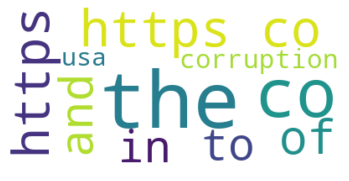

In [165]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(model, topic=0)

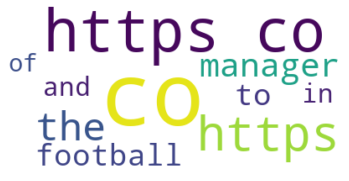

In [166]:
# Show wordcloud
create_wordcloud(model, topic=1)

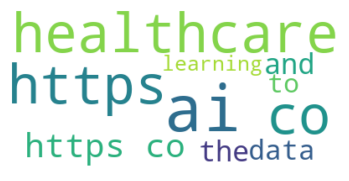

In [167]:
# Show wordcloud
create_wordcloud(model, topic=2)

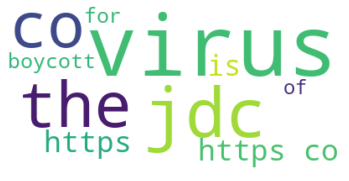

In [168]:
# Show wordcloud
create_wordcloud(model, topic=3)

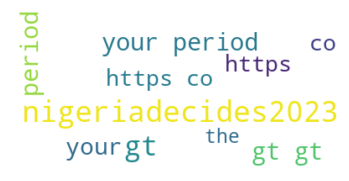

In [169]:
# Show wordcloud
create_wordcloud(model, topic=4)

In [170]:
model.get_topic_info()

Topic  Count                                        Name  \
0      0   1774                     0_the_co_https co_https   
1      1   1009                     1_co_https co_https_the   
2      2    975                    2_ai_healthcare_co_https   
3      3    499                          3_virus_jdc_the_co   
4      4    311  4_nigeriadecides2023_gt_your period_period   

             CustomName  
0                sports  
1     ai and healthcare  
2              disaster  
3  nigeria and politics  
4                   NaN

In [171]:
hierarchical_topics = model.hierarchical_topics(docs)

100%|██████████| 3/3 [00:00<00:00, 27.50it/s]


In [172]:
tree = model.get_topic_tree(hierarchical_topics)
print(tree)

.
├─■──virus_jdc_the_co_https co ── Topic: 3
└─co_https_https co_the_and
     ├─the_co_https co_https_to
     │    ├─■──co_https co_https_the_manager ── Topic: 1
     │    └─■──the_co_https co_https_of ── Topic: 0
     └─■──ai_healthcare_co_https_https co ── Topic: 2



In [173]:
hierarchical_topics

Parent_ID                Parent_Name        Topics Child_Left_ID  \
2         6  co_https_https co_the_and  [0, 1, 2, 3]             3   
1         5  co_https_https co_the_and     [0, 1, 2]             4   
0         4   the_co_https co_https_to        [0, 1]             1   

                 Child_Left_Name Child_Right_ID  \
2      virus_jdc_the_co_https co              5   
1       the_co_https co_https_to              2   
0  co_https co_https_the_manager              0   

                  Child_Right_Name  Distance  
2        co_https_https co_the_and  0.776413  
1  ai_healthcare_co_https_https co  0.594107  
0         the_co_https co_https_of  0.435690

In [174]:
# len(hierarchical_topics)
# # 3

In [177]:
model.visualize_hierarchy()

### **Exporting the model**

In [7]:
# # Saving the model
# model.save("model_list_versions/topics_7/topics_7_model",save_embedding_model=False)

**Observations**

- Topic 0 is related to USA and politics
- Topic 1 is related to  sports.
- Topic 2 is related to AI and healthcare.
- Topic 3 is related to disaster/disease.
- Topic 4 is related to Nigeria and politics.